In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
from torch.autograd import Variable

"""Change to the data folder"""
train_path = "./new_train/"
val_path = "./new_val_in/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=train_path)
val_dataset =  ArgoverseDataset(data_path=val_path)

In [3]:
batch_sz = 32

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    #a_id =[numpy.dstack([scene['agent_id']]) for scene in batch]
    #t_id =[numpy.dstack([scene['track_id']]) for scene in batch]
    #inp = torch.LongTensor(inp)
    #out = torch.LongTensor(out)
    inp =  torch.FloatTensor(inp)
    out =  torch.FloatTensor(out)
    
    return [inp, out]

In [32]:
batch_sz = 32

def my_collate2(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    #out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    a_id =[numpy.dstack([scene['agent_id']]) for scene in batch]
    t_id =[numpy.dstack([scene['track_id']]) for scene in batch]
    s_id =[numpy.dstack([scene['scene_idx']]) for scene in batch] 
    #inp = torch.LongTensor(inp)
    #out = torch.LongTensor(out)
    inp =  torch.FloatTensor(inp)
    #out =  torch.FloatTensor(out)
    
    return [inp,a_id,t_id,s_id]

In [33]:
train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=1)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate2, num_workers=1)

In [6]:
from torch import nn,optim
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel,self).__init__()
        
        self.linear = nn.Linear(240*19, 240*30)
        #self.linear = nn.Linear(1920*19, 1920*30)
        
    def forward(self,x):
        x = self.linear(x)
        return x
    def forward_test(self,x,num_steps= 30):
        res = []
        h = torch.zeros((self.num_layers,len(x),self.hidden_dim)).cuda()
        c = torch.zeros((self.num_layers,len(x), self.hidden_dim)).cuda()
        for step in range(num_steps):
            x,(h,c) = self.lstm(x,(h,c))
            x = x[:,-1:]
            x = x.transpose(1,2)
            x = self.linear(x)
            x = x.transpose(1,2)
            res.append(x)
        res = torch.cat(res,1)
        return res
    

In [7]:
model = LinearModel().cuda()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
loss_ema = -1
loss_ema2 = -1

In [94]:
rmse = []
for epoch in range(1):
    for i_batch , sample_batch in enumerate(train_loader):
        inp,out = sample_batch
        
        inp = inp.cuda()
        out = out.cuda()
        #mixed = torch.cat([inp,out],2).transpose(1,2).reshape((-1,49,240))
        mixed = torch.cat([inp,out],2).transpose(1,2).reshape((-1,49,1920))
        
        #print(mixed.shape)
        
        #immediate =inp.reshape((len(inp),-1)).reshape((-1,60,30,4))
        #print(immediate.shape)
        
       # y_pred = model(inp.reshape((len(inp),-1))).reshape((-1,60,30,4))
        y_pred = model(inp.reshape((len(inp),-1))).reshape((-1,60,30,4))
        
        #inter = mixed.reshape((len(mixed),-1)).reshape((-1,60,30,4))
        #print(inter.shape)
        #y_pred =model(mixed.reshape((len(mixed),-1))).reshape((-1,60,30,4))
        
        
        loss = (torch.mean((y_pred - out )**2))**0.5
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        rmse.append(loss.item())
        
        if loss_ema < 0 :
            loss_ema = loss
        loss_ema = loss_ema*0.99+ loss*0.01
        
        if i_batch %10 == 0:
            print("loss full", epoch, i_batch, loss_ema.item(),loss.item())
        
        if i_batch > 1000:
            break

loss full 0 0 87.49617004394531 68.19512176513672
loss full 0 10 85.85553741455078 79.92372131347656
loss full 0 20 88.91903686523438 78.42240905761719
loss full 0 30 91.70965576171875 102.36736297607422
loss full 0 40 96.4473876953125 247.16363525390625
loss full 0 50 100.29150390625 120.6444320678711
loss full 0 60 99.97003173828125 71.14935302734375
loss full 0 70 97.98014068603516 62.55765914916992
loss full 0 80 95.46089172363281 64.25767517089844
loss full 0 90 94.62206268310547 68.47938537597656
loss full 0 100 93.46619415283203 73.01459503173828
loss full 0 110 93.45829010009766 70.09001922607422
loss full 0 120 95.35369873046875 98.36685943603516
loss full 0 130 95.91451263427734 120.68022155761719
loss full 0 140 96.51313781738281 108.8316879272461
loss full 0 150 96.66153717041016 86.76351928710938
loss full 0 160 94.63761901855469 72.73005676269531
loss full 0 170 97.20808410644531 77.86093139648438
loss full 0 180 99.3890380859375 85.08949279785156
loss full 0 190 100.2407

In [101]:
print(y_pred.shape)
print(out.shape)

torch.Size([32, 60, 30, 4])
torch.Size([32, 60, 30, 4])


[327.49667 354.00006 298.12875 321.45328 318.24274 350.60526 290.3944
 319.13913 295.2973  300.56476 318.6984  357.53247 347.57062 360.32175
 296.33167 342.7173  295.6235  352.72507 358.72443 343.76248 314.91757
 305.6065  340.26437 318.6283  308.53256 362.29016 303.811   277.53326
 279.85477 329.6904 ]


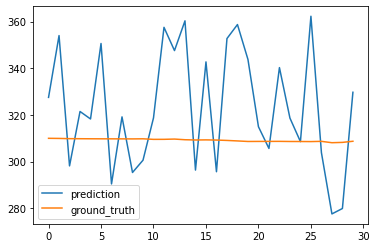

In [113]:
import matplotlib.pyplot as plt
x_truth = []
y_truth = []
x_p = []
y_p = []
p =  y_pred[0,1,:,:2]
x_p = p[:,0]
x_p = x_p.cpu()
x_p = x_p.detach().numpy()
y_p = p[:,1]
print(x_p)
t = out[0,1,:,:2]
x_t = t[:,0]
x_t = x_t.cpu()
x_t = x_t.detach().numpy()
y_t = t[:,1]
plt.plot(range(30),x_p,label= "prediction")
plt.plot(range(30),x_t,label= "ground_truth")
plt.legend()
plt.show()

10020


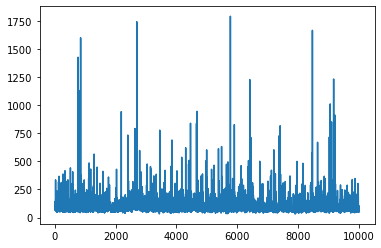

In [62]:
print(len(rmse))
#import matplotlib.pyplot as plt
plt.plot(range(10020),rmse)
#avrg = rmse / 10020
#plt.plot(range(10020),sum(rmse)/len(rmse))
plt.show()



In [37]:
#Find the index of an agent_id within the track_id of a current scence 
def find_index(track_id, agent_id):
    track_id = list(track_id)
    index = track_id.index(agent_id)
    return index

In [89]:
#   for epoch in range(20):
# y = ["v1", "v2", "v3", "v4", "v5", "v6", "v7", "v8", "v9", "v10", "v11", "v12", "v13", "v14", "v15", "v16", "v17", "v18", "v19", "v20", "v21", "v22", "v23", "v24", "v25", "v26", "v27", "v28", "v29", "v30", "v31", "v32", "v33", "v34", "v35", "v36", "v37", "v38", "v39", "v40", "v41", "v42", "v43", "v44", "v45", "v46", "v47", "v48", "v49", "v50", "v51", "v52", "v53", "v54", "v55", "v56", "v57", "v58", "v59", "v60"]
final_result = []
for i_batch , sample_batch in enumerate(val_loader):
    inp,a_id,t_id,s_id = sample_batch
    
    s_id = list(numpy.concatenate(s_id).flat)
    a_id = list(numpy.concatenate(a_id).flat)
    t_id = numpy.array(t_id)
    
    index_list_per_batch = []
    print("SceneIds: {}".format(s_id))
    for i in range(32):
        flat_t_id = numpy.array(t_id[i])
        flat_t_id = flat_t_id[:,0,0]
        current_agent_id = a_id[i]
        #print(flat_t_id)
        #print(current_agent_id)
        index = find_index(flat_t_id, current_agent_id)
        #print(index)
        index_list_per_batch.append(index)
    
    #print("AgentId Indexes for all 32 scenes: {} ".format(index_list_per_batch))
    inp = inp.cuda()
        
    
    y_pred = model(inp.reshape((len(inp),-1))).reshape((-1,60,30,4))
    y_pred = y_pred[:,:,:,[0,1]]
    #print("Prediction Tensor Size(32 scenes) {}".format(y_pred.shape))
    
    for i in range(32):
        row_result = y_pred[i,index_list_per_batch[i],:,:]
        #print("Tensor after i select agent row from  prediction \n {}".format(row_result.shape))
        
        row_result = torch.flatten(row_result)
        #print(row_result)  
        
        
        row_result = row_result.cpu()
        row_result = row_result.detach().numpy()
        row_result = numpy.hstack(([s_id[i]], row_result))
        final_result.append(row_result)
        #ow_result = [s_id[i]] + row_result
        #print(row_result)
        
    
    
    
    
    
    
   
     

SceneIds: [10002, 10015, 10019, 10028, 1003, 10069, 10075, 10078, 10082, 10095, 10096, 10116, 10161, 10165, 10189, 10196, 10200, 10214, 10219, 10232, 10240, 10242, 10250, 10251, 10278, 10279, 10281, 10298, 10303, 10312, 10313, 10317]
SceneIds: [10340, 10355, 10357, 10360, 10361, 10374, 104, 10413, 10439, 10449, 10467, 10472, 10474, 10487, 10495, 10517, 10521, 10523, 10535, 10545, 10560, 10561, 10589, 10605, 10646, 1065, 10662, 10693, 10699, 10701, 10705, 10744]
SceneIds: [10750, 10759, 1076, 10778, 1078, 10797, 10802, 10810, 10816, 10819, 10828, 10836, 10896, 10909, 10910, 10916, 10945, 10947, 10951, 10967, 10994, 10995, 10999, 11002, 11015, 11019, 11025, 11039, 11042, 11067, 11070, 11089]
SceneIds: [11100, 11104, 11110, 11114, 11148, 11152, 11157, 11173, 11193, 11201, 11204, 11211, 11220, 11221, 11225, 11227, 1123, 11232, 11244, 11260, 11261, 11268, 11281, 11286, 11305, 11312, 11340, 1137, 11372, 11381, 11383, 11388]
SceneIds: [11399, 11402, 11424, 11449, 11450, 11465, 11474, 11489, 1

In [91]:
print(len(final_result))

3200


In [92]:
# y = ["v1", "v2", "v3", "v4", "v5", "v6", "v7", "v8", "v9", "v10", "v11", "v12", "v13", "v14", "v15", "v16", "v17", "v18", "v19", "v20", "v21", "v22", "v23", "v24", "v25", "v26", "v27", "v28", "v29", "v30", "v31", "v32", "v33", "v34", "v35", "v36", "v37", "v38", "v39", "v40", "v41", "v42", "v43", "v44", "v45", "v46", "v47", "v48", "v49", "v50", "v51", "v52", "v53", "v54", "v55", "v56", "v57", "v58", "v59", "v60"]
final = numpy.array(final_result)
# var = numpy.stack((y, final))
print(final)
#numpy.savetxt("submission.csv", final, delimiter=",")


[[10002.          1702.30212402   343.4074707  ...   405.5793457
   1745.73205566   363.7663269 ]
 [10015.           731.24884033  1231.1385498  ...  1214.49987793
    727.10314941  1205.20837402]
 [10019.           556.20489502  1246.62097168 ...  1235.83166504
    578.31420898  1250.1385498 ]
 ...
 [ 9905.          1743.47314453   445.6784668  ...   513.64685059
   1791.1652832    463.41409302]
 [ 9910.           545.81164551  1328.59094238 ...  1305.23925781
    621.52514648  1239.25097656]
 [ 9918.           606.27734375  1186.91906738 ...  1136.44494629
    551.60394287  1167.81750488]]


In [93]:

# final.to_csv("Final_Solution")
numpy.savetxt("submission.csv", final, delimiter=",")
